####**Análise de Mídias Sociais**
*by [Miguel S. Machado](https://www.linkedin.com/in/miguel-machado-6655511a6/)*

---

# Analisando dados do Twitter - **Covid-19** (04 de Junho de 2020)

O estudo a abaixo tem como objetivo mostrar a relevância de um diagrama de relacionamentos para compressão do cenário atual.

Vivemos em um mundo onde a tecnologia está em constante desenvolvimento e  presente em todas as atividades que desempenhamos. Com essa evoulução, em um curto período de tempo as pessoas deixaram de ser simples consumidores passivos de informação e começaram a ganhar voz!
Hoje qualquer pessoa com um celular na mão pode se tornar um produtor de conteúdo e influenciador de pessoas pela internet.
Entender como as pessoas se posiocionam sobre um determinado assunto e quem são os principais ativistas desse assunto é muito importate. Se você é um jornalista, entender um diagrama de relacionamentos irá lhe proporcionar uma visão do todo e não só de um lado da moeda. Se você é um empresario, pode ver quem são os mais ativos e maiores influenciadores em assuntos associados a sua marca. Os usos desse tipo de informação são ilimitados.

Chega de conversa e vamos colocar as mãos na massa e entender o diagrama de relacionamentos sobre um dos principais assuntos do momento, infelizmente, o COVID-19.

Para realizar esse estudo serão utilizados 3 ferramentas:
- A primeira delas é o [FacePager](https://https://github.com/strohne/Facepager), que nos possibilitará a busca de dados no Twitter e criação do nosso arquivo quer irá gerar o nosso DataFrame;
- A segunda é a nossa poderosa linguagem de programação: Python. Com algumas bibliotecas fundamentais como Pandas, Matplotlib e Seaborn;
- E por último o [Gephi](https://https://gephi.org/users/download/), que será o grande responsável pela criação do diagrama de relacionamentos.


#**Entendendo o FacePager**

## Definição
O FacePager é uma ferramenta OpenSource que possibilita uma busca automatizada em algumas mídias sociais, como Twitter, Facebook e YouTube.

No nosso estudo, faremos um busca no Twitter. E para isso precisamos de uma conta para fazer o login (1). Feito o login, temos que criar um database (2). Se você nem sabe o que é, não se preocupe, não irá ultizar! O próximo passo é escolher os *Nodes* (3), que são nada mais nada menos que as palavras chaves. Agora vamos ajustar os padrões de busca (4), e quando tudo estiver conforme o desejado, selecione todos os nós e clique em `Fetch Data`.

Agora basta aguardar que os dados sejam coletados para que possamos iniciar o processo de exportação do arquivo *.csv*.

Antes de exportarmos, vamos selecionar as colunas que nos importam (5). E, finalmente, selecionar todos os nós e exportar (6) o arquivo *.csv*.

![Facepager](https://github.com/miguelsmachado/data_science/blob/master/Analise_midias_sociais/facepager_01.png?raw=true)

#**Filtrando os dados com _Python_** 

## Importando as bibliotecas
Nosso primeiro passo é importar e instalar as bibliotecas que iremos trabalhar

In [0]:
!pip install wordcloud -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Criando o DataFrame e editando as variáveis

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/miguelsmachado/data_science/master/Analise_midias_sociais/covid19.csv", sep=';')

####Visualizando as 5 primeiras linhas do DataFrame

In [4]:
df.head()

,level,id,parent_id,object_id,object_type,query_status,query_time,query_type,user.screen_name,entities.user_mentions.0.screen_name,id.1,created_at,text,retweeted_status.favorite_count,retweeted_status.retweet_count,user.location,retweeted_status.user.location
0,0,1,None,covid-19,seed,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,1,1268357934691516417,data,fetched (200),2020-06-03 22:44:33.196458,Twitter:/search/tweets,camiperdao,brunogagliasso,1.268358e+18,Thu Jun 04 01:44:31 +0000 2020,RT @brunogagliasso: Já que o Ministério da Saú...,1945.0,514.0,Br,Brasil
2,1,3,1,1268357934171422720,data,fetched (200),2020-06-03 22:44:33.196458,Twitter:/search/tweets,mhelenaRS,DCM_online,1.268358e+18,Thu Jun 04 01:44:31 +0000 2020,RT @DCM_online: Freixo acusa ministro da Saúde...,15.0,7.0,"Rio Grande do Sul, Brasil","Sao Paulo, Brazil"
3,1,4,1,1268357932955172866,data,fetched (200),2020-06-03 22:44:33.196458,Twitter:/search/tweets,NeoJoao,Sarahteofilo,1.268358e+18,Thu Jun 04 01:44:30 +0000 2020,"RT @Sarahteofilo: Boletim 3/6 Em 24 horas, for...",2.0,3.0,Goiânia Rock City,Brasília
4,1,5,1,1268357929754857472,data,fetched (200),2020-06-03 22:44:33.196458,Twitter:/search/tweets,jvieiraleonardo,brunogagliasso,1.268358e+18,Thu Jun 04 01:44:30 +0000 2020,RT @brunogagliasso: Já que o Ministério da Saú...,1945.0,514.0,NaN,Brasil


#### Filtrando os dados para o Gephi

In [0]:
# De todas as colunas que recebemos no CSV original, só algumas nos interessam
# O primeiro passo é filtra-las.
df = df[['user.screen_name', 'entities.user_mentions.0.screen_name', 'object_id',
         'created_at', 'text', 'retweeted_status.retweet_count', 'user.location']]

# Agora vamos renomear as colunas para que fiquem mais fácil para nosso trabalho
# e entendimento do Gephi
df.columns = ['source', 'target', 'object_id', 'created_at', 'tweet_text', 
              'retweet_count', 'user.location']

# Como nosso estudo é focado em relacionamentos, não faz sentido com dados que 
# estão desconectados, ou seja, que não retwittes. As postagens que não são 
# retwittes recebem um valor NaN em sua coluna do retweet_count, que podem 
# facilmente ser excluidas com o comando abaixo
df = df.dropna()

#### Visualizando as 5 primeiras linhas do dado filtrado

Podemos ver bem a diferença de como é melhor trabalhar e entender um DataFrame "filtrado".

In [6]:
print(f"O DataFrame possui {df.shape[0]} twetts")
print()
df.head()

O DataFrame possui 15458 twetts



,source,target,object_id,created_at,tweet_text,retweet_count,user.location
1,camiperdao,brunogagliasso,1268357934691516417,Thu Jun 04 01:44:31 +0000 2020,RT @brunogagliasso: Já que o Ministério da Saú...,514.0,Br
2,mhelenaRS,DCM_online,1268357934171422720,Thu Jun 04 01:44:31 +0000 2020,RT @DCM_online: Freixo acusa ministro da Saúde...,7.0,"Rio Grande do Sul, Brasil"
3,NeoJoao,Sarahteofilo,1268357932955172866,Thu Jun 04 01:44:30 +0000 2020,"RT @Sarahteofilo: Boletim 3/6 Em 24 horas, for...",3.0,Goiânia Rock City
5,cbxxss,WendelBrasilSP,1268357929587167234,Thu Jun 04 01:44:30 +0000 2020,RT @WendelBrasilSP: O q mídia progressista não...,28.0,Brasil
6,claudia20653209,RubensNunesMBL,1268357928702095366,Thu Jun 04 01:44:29 +0000 2020,RT @RubensNunesMBL: Infelizmente o Brasil queb...,2.0,"Niterói, Brasil"


#####Agora que temos somentes as colunas necessárias para trabalharmos, vamos explicar uma a uma:

- *source* - Usuário do Twitter que **retwittou** a postagem;
- *target* - Usuário do Twitter criador da postagem **retwittada** (Influenciador)
- *object_id* - Número gerado pelo twitter para o post
- *created_at* - Data da postagem;
- *tweet_text* - Mensagem postada;
- *retweet_count* - Número de vezes que o post foi retwittado

#### Criando a coluna URL

Para que facilitar nossa analise, vamos criar uma nova coluna, manipulando alguns dados do nosso DataFrame e inserir o url do post que gerou o retweet.

A forma geral de um link de retweet é a seguinte:

`https://twitter.com/` **+** `<target>` **+** `/status/` **+** `<object_id>`

In [0]:
for index, row in df.iterrows():
  df.loc[index, 'url'] = 'https://twitter.com/'+str(row['target'])+'/status/'+str(row['object_id'])

In [8]:
# Visualizando a coluna 'url'
df.url.to_frame().head()

,url
1,https://twitter.com/brunogagliasso/status/1268...
2,https://twitter.com/DCM_online/status/12683579...
3,https://twitter.com/Sarahteofilo/status/126835...
5,https://twitter.com/WendelBrasilSP/status/1268...
6,https://twitter.com/RubensNunesMBL/status/1268...


##**Refinando os parâmetros de busca**

A ideia desse trecho de código é verifcar quais palavras, hashtags e menções foram mais utilizadas no nosso DataFrame.

Com essas informações, podemos refazer nosso busca no FacePager de modo a enriquecer nossa base de dados e assim obter uma melhor análise. Caso seja verificado alguma palavra muito relevante que deva ser incluido na busca original, todo processo deve ser refeito até aqui, uma vez que nosso arquivo *.csv* original mudou.

### Criando a lista das palavras mais utilizadas

In [0]:
# criamos um DataFrame novo somente com os dados que precisamos
# como serão feitas muitas verificações, quanto menos dados, mais rápido e fácil 
# os dados serão processados
df_research = df[['target', 'tweet_text']]
# eliminando dados duplicados, pois precisamos de apenas uma mensagem de cada.
df_research = df_research.drop_duplicates()
# separando as palavras
words = df_research
words["tweet_text"] = df_research["tweet_text"].str.lower()
words = words["tweet_text"].str.get_dummies(" ").sum().sort_values(ascending=False)

#### Lista de *Bad Words*:

Vamos criar uma lista com preposições e artigos que não possuem relevância em nossa busca, pois com certeza, essas seriam as que mais se destacariam.

Essa lista não é *padrão*, cada vez que executarmos o código e percebermos que alguma ficou de fora, basta incluir. Assim como se ao executar, recebermos um erro em resposta, basta excluí-la da lista

In [0]:
bad_words = ['rt', 'de', 'e', 'o', 'a', 'em', 'na', 'no', 'de', 'da', 'com',
             'como', 'é', 'do', 'os', 'ou', "que", "não", 'para', 'por', 'mais', 
             'um', 'uma', 'ao', 'as', 'se', 'dos', 'nas', 'já', 'pela', 'pra', 
             'está', 'à', '-', 'das', 'só', 'r$', 'pelo'  
             ]

In [11]:
top_words = words.drop(labels=bad_words)
top_words.to_frame().head(30)

,0
mortes,353
covid-19,347
brasil,297
1.349,295
coronavírus,190
24,161
recorde,157
novo,148
casos,131
32.548,102


####Após essa análise, vimos que o termo **_1.349_** era relevante, pois foi o número de mortes no dia dessa pesquisa, e foi adicionado a busca do FacePager. A busca inicial não continha esse termo.

###Encontrando as hashtags e menções mais utilizadas

Da mesma forma que buscamos as palavras, podemos verificar as hashtags e menções para, novamente, podermos refinar os padrões de busca.

In [0]:
# criando as novas variáveis que serão utilizadas
df_hashtags = df_research
df_hashtags['tweet_text'] = df_research['tweet_text'].str.split()
hashtags = []
mentions = []

# buscando por '#' e '@'
for text in df_hashtags.tweet_text:
  for palavra in text:
    if '#' in palavra:
      hashtags.append(palavra)
    elif '@' in palavra:
      mentions.append(palavra)

# criando as Series com as top# e top@
top_mentions = pd.Series(mentions).str.get_dummies(':').sum().sort_values(ascending=False)
top_hashtags = pd.Series(hashtags).str.get_dummies(' ').sum().sort_values(ascending=False)

####Exibindo as top hashtags

In [13]:
top_hashtags.to_frame().head(10)

,0
#coronavirus,51
#coronavírus,36
#covid19,13
#covid_19,12
#forabol卐onaro,10
#g1,7
#covidー19,7
#anomynousbrasil,6
#coronavírus.,6
#forabolsonaro,5


####Exibindo as top menções

In [14]:
top_mentions.to_frame().head(10)

,0
@jairbolsonaro,33
@minsaude,23
@oatila,20
@folha,15
@secomvc,12
@estadao,11
@rocha06411608,11
@g1,11
@revistaforum,10
@uolnoticias,10


####WordClouds

Apesar de não contribuir para o estudo propriamente, uma wordcloud pode facilitar e enriquecer um apresentação em uma empresa ou para um cliente.

Por esse motivo, vamos criar as *WordClouds* dos **Hashtags** e das **Menções**

##### Hashtags

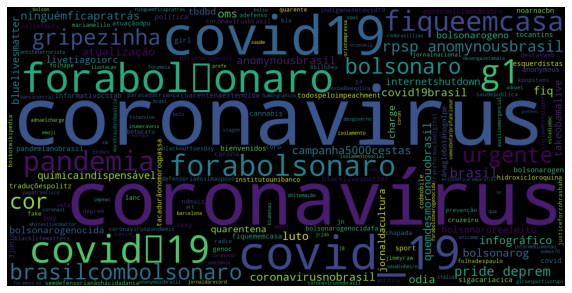

In [15]:
# criando um texto com todas as hashtags
all_hashtags = " ".join(s for s in hashtags)

# criando a wordcloud
wordcloud = WordCloud(background_color="black",
                      width=1600, height=800).generate(all_hashtags)

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# Exibindo a imagem e exportando o arquivo
plt.imshow(wordcloud)
wordcloud.to_file("hashtags_wordcloud.png");

#####Menções

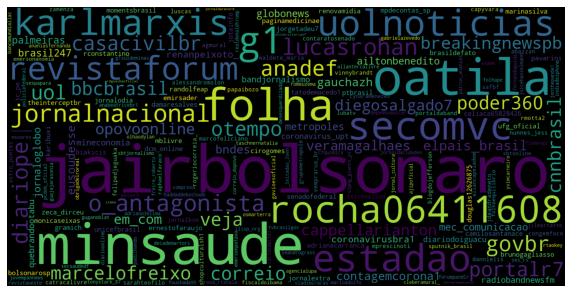

In [16]:
# criando um texto com todas as menções
all_mentions = " ".join(s for s in mentions)

# criando a wordcloud
wordcloud = WordCloud(background_color="black",
                      width=1600, height=800).generate(all_mentions)

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# Exibindo a imagem e exportando o arquivo
plt.imshow(wordcloud)
wordcloud.to_file("mencoes_wordcloud.png");

## Encontrado a localização dos retwitadores

Essa etapa do processo foi criado com um algo a mais, e deve ter seus dados analisado com muito cuidado pois foi criado através de manipulação de strings de onde os usuários colocaram ser suas cidades.

Escritas incorretas ou diferentes (como 021 ao invés de Rio de Janeiro) não irão geral nenhum resultado

Mas de uma forma geral, teremos um panorama de em qual estado do país esta a maior parte da audiência.

###Importando o DataFrame com as cidade so Brasil

In [0]:
df_loc = pd.read_csv("https://raw.githubusercontent.com/miguelsmachado/data_science/master/Analise_midias_sociais/municipios.csv")

In [18]:
# Exibindo as 5 primeiras linhas do DataFrame
df_loc.head()

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31
2,5200100,Abadiânia,-16.19700,-48.7057,0,52
3,3100203,Abaeté,-19.15510,-45.4444,0,31
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15


###Ajustando os DataFrames

Vamos separar somente que precisamos de cada DataFrame

In [0]:
df_municipios = df_loc[['nome', 'codigo_uf']]
df_user_loc = df['user.location']

###Criando *Series* para cada estado

Vamos criar um *Series* para cada estado, onde nela, conterá todas as cidades desse estado

In [0]:
ro = df_municipios.query("codigo_uf==11")['nome'].str.lower()
ac = df_municipios.query("codigo_uf==12")['nome'].str.lower()
am = df_municipios.query("codigo_uf==13")['nome'].str.lower()
rr = df_municipios.query("codigo_uf==14")['nome'].str.lower()
pa = df_municipios.query("codigo_uf==15")['nome'].str.lower()
ap = df_municipios.query("codigo_uf==16")['nome'].str.lower()
to = df_municipios.query("codigo_uf==17")['nome'].str.lower()
ma = df_municipios.query("codigo_uf==21")['nome'].str.lower()
pi = df_municipios.query("codigo_uf==22")['nome'].str.lower()
ce = df_municipios.query("codigo_uf==23")['nome'].str.lower()
rn = df_municipios.query("codigo_uf==24")['nome'].str.lower()
pb = df_municipios.query("codigo_uf==25")['nome'].str.lower()
pe = df_municipios.query("codigo_uf==26")['nome'].str.lower()
al = df_municipios.query("codigo_uf==27")['nome'].str.lower()
se = df_municipios.query("codigo_uf==28")['nome'].str.lower()
ba = df_municipios.query("codigo_uf==29")['nome'].str.lower()
mg = df_municipios.query("codigo_uf==31")['nome'].str.lower()
es = df_municipios.query("codigo_uf==32")['nome'].str.lower()
rj = df_municipios.query("codigo_uf==33")['nome'].str.lower()
sp = df_municipios.query("codigo_uf==35")['nome'].str.lower()
pr = df_municipios.query("codigo_uf==41")['nome'].str.lower()
sc = df_municipios.query("codigo_uf==42")['nome'].str.lower()
rs = df_municipios.query("codigo_uf==43")['nome'].str.lower()
ms = df_municipios.query("codigo_uf==50")['nome'].str.lower()
mt = df_municipios.query("codigo_uf==51")['nome'].str.lower()
go = df_municipios.query("codigo_uf==52")['nome'].str.lower()
df1 = df_municipios.query("codigo_uf==53")['nome'].str.lower()

###Criando nosso banco de dados

Com um dicionário, vamos fazer um banco de dados para servir de contador e armazenador das informações encontradas

In [0]:
contador_de_cidades = {'ro': 0,'ac': 0,'am': 0,'rr': 0,'pa': 0,'ap': 0,'to': 0,
                       'ma': 0,'pi': 0,'ce': 0,'rn': 0,'pb': 0,'pe': 0,'al': 0,
                       'se': 0,'ba': 0,'mg': 0,'es': 0,'rj': 0,'sp': 0,'pr': 0,
                       'sc': 0,'rs': 0,'ms': 0,'mt': 0,'go': 0,'df1': 0
                       }

###Buscando as cidades

Através de algumas linhas de códigos, vamos manipular as strings e tentar encontrar o máximo de informações possíveis através de loops.

**Denpendendo do tamnho do DataFrame, esse processo pode demorar um pouco.**

In [0]:
# criando uma lista para armazenar os dados que não forem encontrados
nao_encontradas = [] 

for linha in df_user_loc.values:
  for cidade in linha.lower().split(','):
    if cidade.strip() in ro.values:
      contador_de_cidades['ro'] += 1
      break
    elif cidade.strip() in ac.values:
      contador_de_cidades['ac'] += 1
      break
    elif cidade.strip() in am.values:
      contador_de_cidades['am'] += 1
      break
    elif cidade.strip() in rr.values:
      contador_de_cidades['rr'] += 1
      break
    elif cidade.strip() in pa.values:
      contador_de_cidades['pa'] += 1
      break
    elif cidade.strip() in ap.values:
      contador_de_cidades['ap'] += 1
      break
    elif cidade.strip() in to.values:
      contador_de_cidades['to'] += 1
      break
    elif cidade.strip() in ma.values:
      contador_de_cidades['ma'] += 1
      break
    elif cidade.strip() in pi.values:
      contador_de_cidades['pi'] += 1
      break
    elif cidade.strip() in ce.values:
      contador_de_cidades['ce'] += 1
      break
    elif cidade.strip() in rn.values:
      contador_de_cidades['rn'] += 1
      break
    elif cidade.strip() in pb.values:
      contador_de_cidades['pb'] += 1
      break
    elif cidade.strip() in pe.values:
      contador_de_cidades['pe'] += 1
      break
    elif cidade.strip() in al.values:
      contador_de_cidades['al'] += 1
      break
    elif cidade.strip() in se.values:
      contador_de_cidades['se'] += 1
      break
    elif cidade.strip() in ba.values:
      contador_de_cidades['ba'] += 1
      break
    elif cidade.strip() in mg.values:
      contador_de_cidades['mg'] += 1
      break
    elif cidade.strip() in es.values:
      contador_de_cidades['es'] += 1
      break
    elif cidade.strip() in rj.values:
      contador_de_cidades['rj'] += 1
      break
    elif cidade.strip() in sp.values:
      contador_de_cidades['sp'] += 1
      break
    elif cidade.strip() in pr.values:
      contador_de_cidades['pr'] += 1
      break
    elif cidade.strip() in sc.values:
      contador_de_cidades['sc'] += 1
      break
    elif cidade.strip() in rs.values:
      contador_de_cidades['rs'] += 1
      break
    elif cidade.strip() in ms.values:
      contador_de_cidades['ms'] += 1
      break
    elif cidade.strip() in mt.values:
      contador_de_cidades['mt'] += 1
      break
    elif cidade.strip() in go.values:
      contador_de_cidades['go'] += 1
      break
    elif cidade.strip() in df1.values:
      contador_de_cidades['df1'] += 1
      break
    else:
      nao_encontradas.append(cidade.strip())

####Visualizando o Dicionário preenchido

In [23]:
contador_de_cidades

{'ac': 4,
 'al': 87,
 'am': 116,
 'ap': 27,
 'ba': 276,
 'ce': 213,
 'df1': 372,
 'es': 121,
 'go': 204,
 'ma': 125,
 'mg': 683,
 'ms': 15,
 'mt': 51,
 'pa': 187,
 'pb': 136,
 'pe': 325,
 'pi': 88,
 'pr': 325,
 'rj': 1544,
 'rn': 239,
 'ro': 32,
 'rr': 7,
 'rs': 445,
 'sc': 237,
 'se': 45,
 'sp': 2039,
 'to': 63}

###Gerando o gráfico com os Estados com mais "retwitadores"

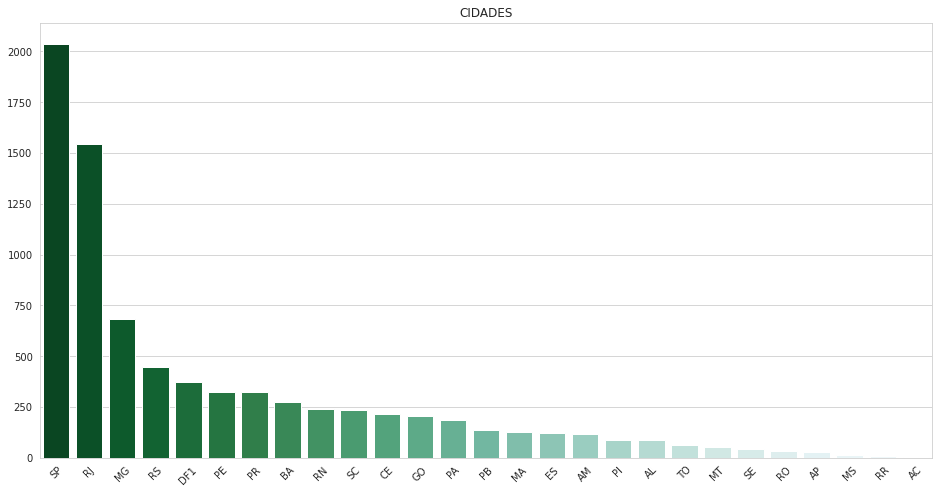

In [24]:
grafico = pd.Series(data=contador_de_cidades).sort_values(ascending=False)

plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")
plt.xticks(rotation=45)

sns.barplot(x=grafico.index.str.upper(),
            y=grafico.values,
            palette=sns.color_palette("BuGn_r", n_colors=len(grafico.index))).set_title("CIDADES");

## Gerando o gráfico dos maiores influenciadores

Aqui, iremos exibir um gráfico com os maiores influenciadores.

Esse gráfico não substitui o diagrama de relacionamentos, que não só irá exibir as maiores influencias, como seus relacionamentos. Mas já da para ter uma ideia de o que teremos como resultado

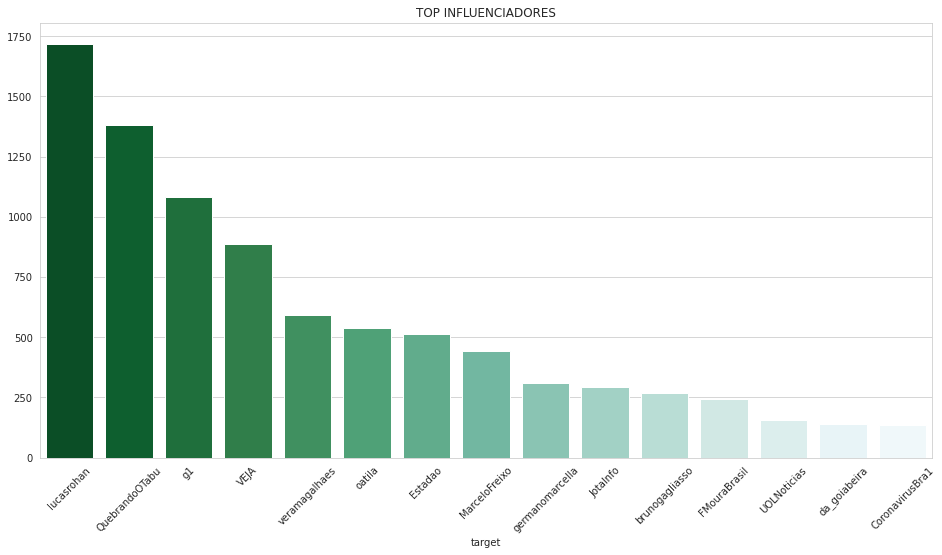

In [25]:
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")
plt.xticks(rotation=45)

graph_retweet = df.groupby('target')['target'].count().sort_values(ascending=False).head(15)
sns.barplot(x=graph_retweet.index,
            y=graph_retweet.values,
            palette=sns.color_palette("BuGn_r", n_colors=len(graph_retweet.index))).set_title("TOP INFLUENCIADORES");

##Exportando o arquivo .csv

In [0]:
df.to_csv('data_gephi.csv', index=False)

##### Com essa exportação, podemos salvar esse arquivo para utiliza-lo no Gephi



#Utilizando o **Gephi**

O Gephi é um programa que gera um gráfico de relacionamentos apartir de informações inseridas.

Podemos faze-lo de forma manual, o que é muito difícil e dificilmente iremos conseguir uma grande quantidade de dados (Esse nosso DataFrame possui quase 15500 relacionametos).

Ou podemos inserir um arquivo *.csv* (o que estamos fazendo) e gerar nosso diagrama de relacionamentos.



### Inserindo os dados

Ao inicializar o programa, vamos clicar em: `Arquivo` -> `Importar Planilha`

Selecione o arquivo gerado aqui e conclua a importação.

Assim que importarmos o arquivos teremos uma visão de algo estranho e sem sentido nenhum:

![Gephi01](https://github.com/miguelsmachado/data_science/blob/master/Analise_midias_sociais/gephi_01.png?raw=true)

Está pronto! Aqui estão todos os twittes! Agora é só analisar!

Calma...

Vamos rodar alguns algoritimos do Gephi para tornar isso mais compressível:
- Primeiro vamos ajustar algumas estatísticas(1):
  - No item `Modularidade` e clicar em `Executar`
- Agora vamos ajustar algumas aparências(2):
  - Sempre vamos ajustar os nós;
  - Escolha a opção tamanho(3), depois `Ranking`-> `Grau de Entrada` -> `Aplicar`
  - Agora, na opção cores(4), escolha `Partition`-> `Modularity Class` -> `Aplicar`
- Vamos dar vida a esse diagrama ajustando a distribuição(5):
  - Na caixa, `Escolha um distribuição`, selecione `OpenOrd` e `Executar`
  - Quando finalizar, escolha `Force Atlas 2`, marque a opção *evitar sobreposições* e clique em `Executar`;
  - Obs.: O Force Atlas 2 nunca para de executar. Quando julgar que está como gostaria, é só parar.
- Por fim, vamos colocar os nomes nos nós:
  - Clique no botão no canto inferior direito(6), se esta aba estiver abaixada;
  - Clique em atributos(7) e deixe selecionada somente a opção `Id`;
  - Selecione `**Rótulos**`e por fim marque as seguintes caixas: `Esconder não selecionadas`e `Nó`

**Agora sim!!! Tudo pronto**

![Gephi02](https://github.com/miguelsmachado/data_science/blob/master/Analise_midias_sociais/gephi_02.png?raw=true)

Com a ajuda do **PhotoShop**, vamos dar uns ajustes nesse diagrama para facilitar nossa compreensão:

![Gephi03](https://github.com/miguelsmachado/data_science/blob/master/Analise_midias_sociais/gephi_03_1.png?raw=true)

**Vamos a uma pequena análise:**
- Como podemos ver existem alguns *"Círculos de Relacionamentos"*;
- O principal está na cor azul e tem como centro **lucashoran**;
- Dentro dele, temos um subgrupo em vermelho e tem como centro **Marcelo Freixo**;
- Os círculos em amarelo nos mostram grupos isolados, cada um com a sua própria liderança e com pouco ou muito pouco relacionamento com o grupo principal;
- Dentre eles, se destaca o grupo do **QuebrandoOTabu**, que possui uma grande audiência, porém com quase nenhum relacionamento com o grupo principal.

Com o Gephi, podemos passar o mouse em cima dos nós e saber quem é cada um daqueles usuários.

Agora cabe a cada profissional, aprofundar suas buscar e extrair as informações detalhadas que julgarem importantes para sua área.

Todas as informações do mundo estão disponíveis, torna-se diferenciado, quem consegue transformá-las em conhecimento!